In [46]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
from google.cloud import storage
import os
import matplotlib.pyplot as plt  # Import Matplotlib for plotting
import seaborn as sns  # Import Seaborn for advanced visualization

# Onjective of this program is to extract data from given URL using web scraping and save csv version of that data set in the Google cloud 
# ----------------------------------------------------------------------------------------------------------------------------------------

# Step 1: Web Scraping 

# used below URL of the web page to extract data 
url = "https://www.statistics.gov.lk/Agriculture/StaticalInformation/PaddyStatistics/Annual-BothSeasons-1952-2015"

# Web Scraping 
response = requests.get(url)
response.raise_for_status()  # Check for request errors

soup = BeautifulSoup(response.text, 'html.parser')

tables = soup.find_all('table')
table = tables[-1]  # Last Table taken to eliminate unwanted dats set 

# Extract table data
data = []
for row in table.find_all('tr'):
    cells = row.find_all(['th', 'td'])
    cell_data = [cell.get_text(strip=True) for cell in cells]
    if len(cell_data) > 3:  # Filter out unwanted rows
        data.append(cell_data)

# Ensure rows have equal columns
max_columns = max(len(row) for row in data)
for row in data:
    row += [""] * (max_columns - len(row))  # Fill missing cells with empty strings

# Create DataFrame and set first row as header
df = pd.DataFrame(data[1:], columns=data[0])

# Convert DataFrame to CSV string
csv_data = df.to_csv(index=False)

# ---------------------------------------------------------------------------------------------------------------
# Setp 2 - Upload csv file to Google Cloud

# Google Cloud authentication
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "C:/Users/suneth.jayamanne/msc-project-portfolio-8c9eb0909b58.json"

# Initialize Google Cloud Storage client
client = storage.Client()

# Define bucket and destination filename
bucket_name = "paddy_statistics"  
destination_blob_name = "paddy_statistics_1952_2015.csv"

# Upload the data to the Google Cloud Storage
bucket = client.bucket(bucket_name)
blob = bucket.blob(destination_blob_name)
blob.upload_from_string(csv_data, content_type='text/csv')

print(f"Dataset uploaded to GCS bucket '{bucket_name}' as '{destination_blob_name}'!")


Dataset uploaded to GCS bucket 'paddy_statistics' as 'paddy_statistics_1952_2015.csv'!


In [47]:
# Step 3 - Download the file from GCS to working folder 

downloaded_file_path = "D:/Personal/MSc/MSc. Data Science/Lecture Notes/2. Principles of DS/Assignment and Passpapers/Assignments/Portfolio/paddy_statistics_1952_2015_downloaded.csv"
blob.download_to_filename(downloaded_file_path)
print(f"File downloaded from GCS to '{downloaded_file_path}'")

File downloaded from GCS to 'D:/Personal/MSc/MSc. Data Science/Lecture Notes/2. Principles of DS/Assignment and Passpapers/Assignments/Portfolio/paddy_statistics_1952_2015_downloaded.csv'


In [48]:
# Step 4 - Load the cleansed file to do EDA
file_path = "D:/Personal/MSc/MSc. Data Science/Lecture Notes/2. Principles of DS/Assignment and Passpapers/Assignments/Portfolio/paddy_statistics_1952_2015_cleansed.csv"
df = pd.read_csv(file_path)
print("cleansed file loaded")

cleansed file loaded


    Cultivation Year  Sown (000 Ha)  Harvested (000 Ha.)  \
0               1952            471                  446   
1               1953            425                  385   
2               1954            508                  486   
3               1955            545                  520   
4               1956            476                  426   
..               ...            ...                  ...   
59              2011           1223                 1102   
60              2012           1067                  990   
61              2013           1228                 1189   
62              2014            964                  881   
63              2015           1254                 1211   

    Average Yield (Kg/Ha)  Production (000 Mt.)  
0                    1588                   604  
1                    1392                   458  
2                    1548                   650  
3                    1673                   746  
4                    1549    

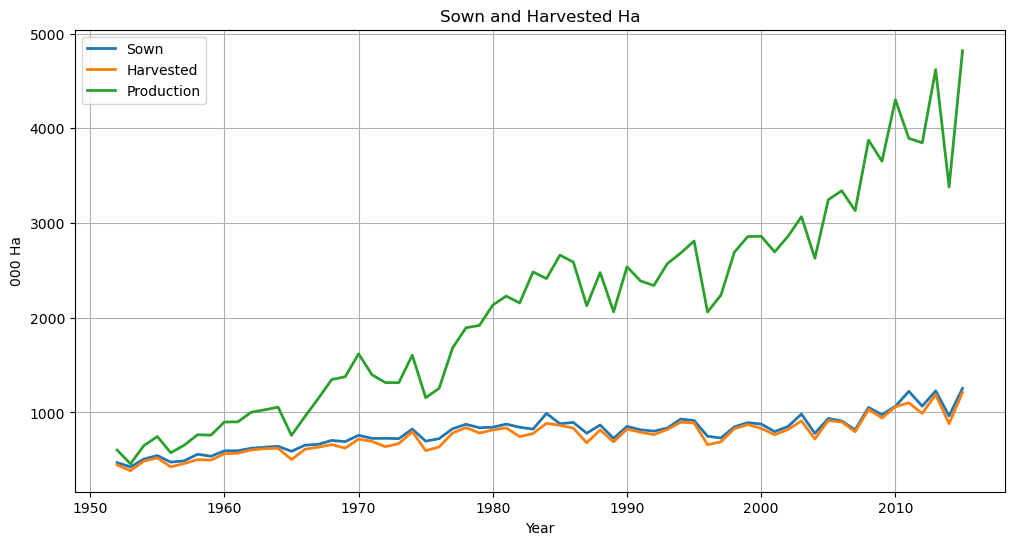

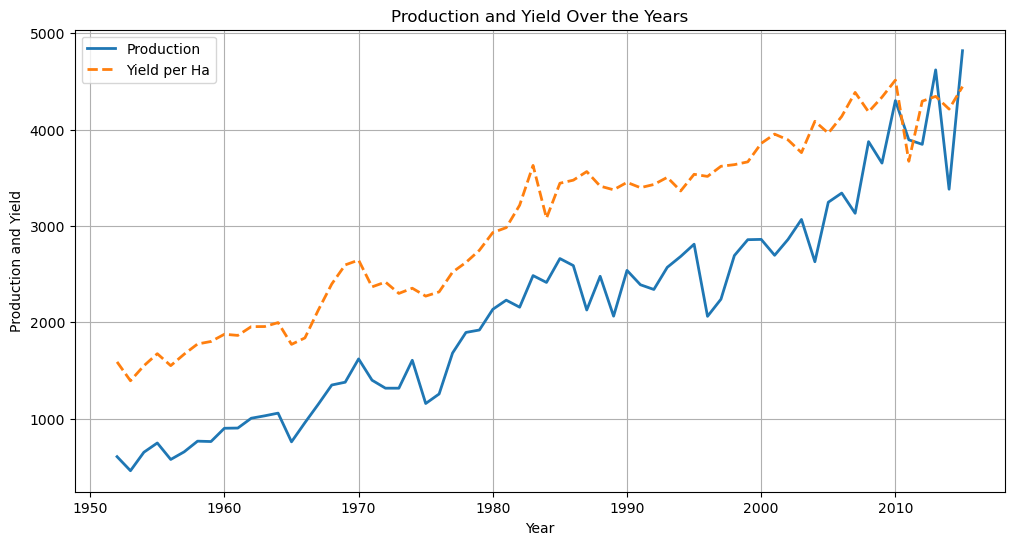

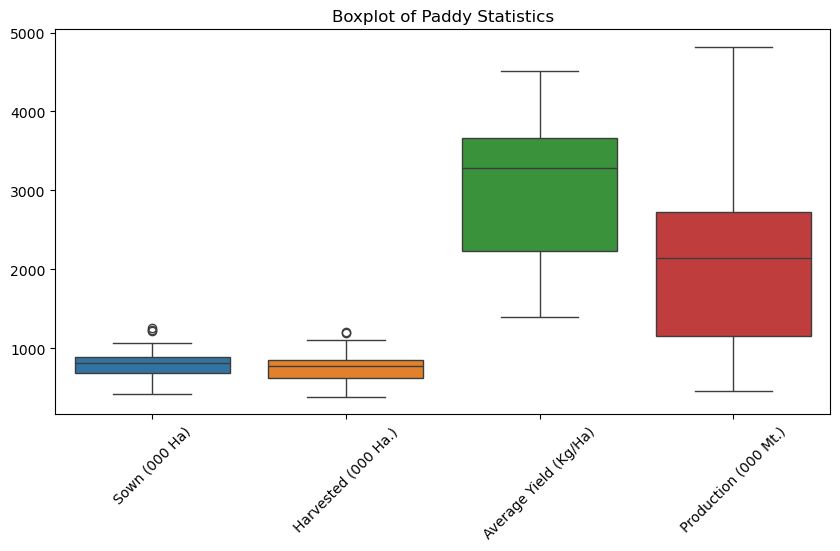

<Figure size 1000x500 with 0 Axes>

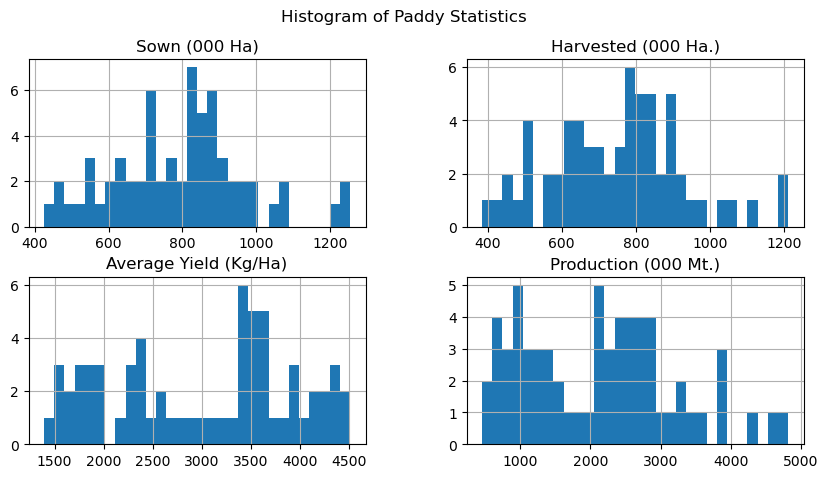

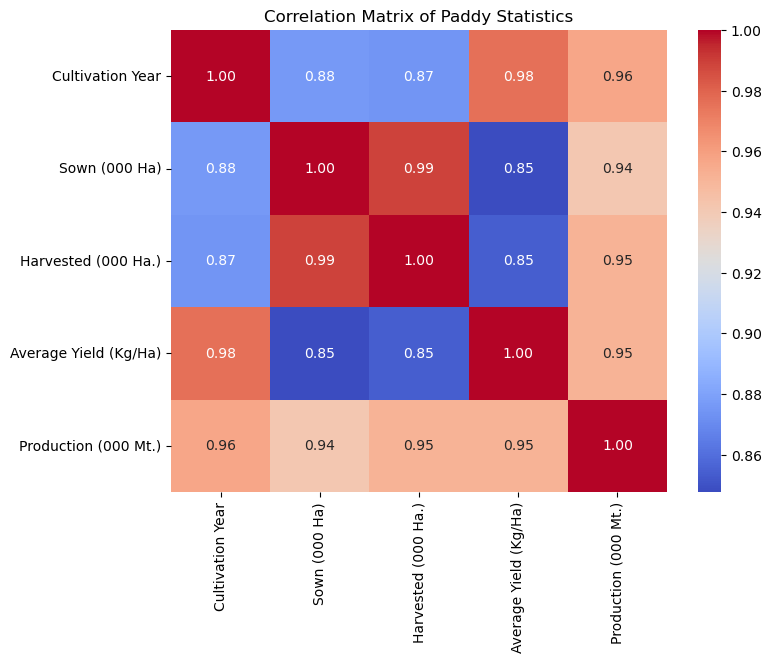

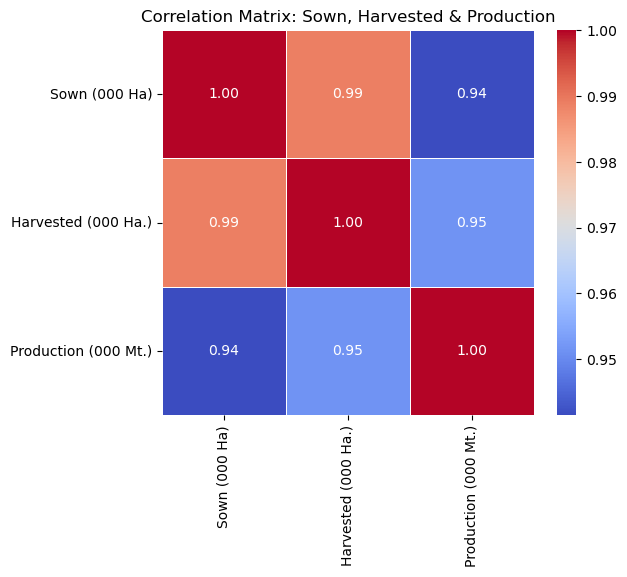

In [49]:
# Step 5 - Exploratory Data Analysis (EDA)

print(df) 
print(df.info())
print(df.describe())

# Convert relevant columns to numeric (handle errors)
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.fillna(df.mean(), inplace=True)

# Visualizations
# Line Plot 
plt.figure(figsize=(12, 6))
plt.plot(df['Cultivation Year'], df['Sown (000 Ha)'], label='Sown', linewidth=2)
plt.plot(df['Cultivation Year'], df['Harvested (000 Ha.)'], label='Harvested', linewidth=2)
plt.plot(df['Cultivation Year'], df['Production (000 Mt.)'], label='Production', linewidth=2)

plt.xlabel('Year')
plt.ylabel('000 Ha')
plt.title('Sown and Harvested Ha')
plt.legend()
plt.grid(True)
plt.show()

# Trend Analysis for Yield
plt.figure(figsize=(12, 6))
plt.plot(df['Cultivation Year'], df['Production (000 Mt.)'], label='Production', linewidth=2)
plt.plot(df['Cultivation Year'], df['Average Yield (Kg/Ha)'], label='Yield per Ha', linewidth=2, linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Production and Yield')
plt.title('Production and Yield Over the Years')
plt.legend()
plt.grid(True)
plt.show()

# Boxplot 
plt.figure(figsize=(10, 5))
sns.boxplot(data=df.iloc[:, 1:])
plt.title("Boxplot of Paddy Statistics")
plt.xticks(rotation=45)
plt.show()

# Histrogram 
plt.figure(figsize=(10, 5))
df.iloc[:, 1:].hist(bins=30, figsize=(10, 5))
plt.suptitle("Histogram of Paddy Statistics")
plt.show()

# Correlation Heatmap 
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix of Paddy Statistics")
plt.show()

# Additional Correlation Heatmap (Only Sown, Harvested, and Production) 
plt.figure(figsize=(6, 5))
selected_cols = ['Sown (000 Ha)', 'Harvested (000 Ha.)', 'Production (000 Mt.)']
sns.heatmap(df[selected_cols].corr(), annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)

plt.title("Correlation Matrix: Sown, Harvested & Production")
plt.show()



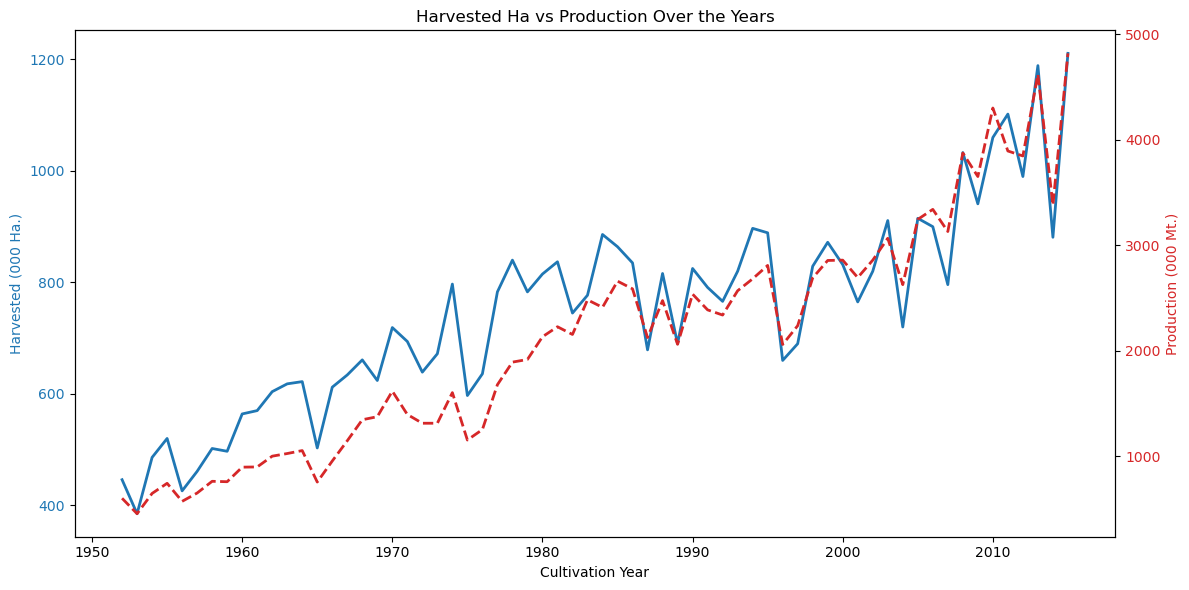

In [50]:
import matplotlib.pyplot as plt

# Create figure and axis
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary y-axis (left)
ax1.set_xlabel('Cultivation Year')
ax1.set_ylabel('Harvested (000 Ha.)', color='tab:blue')
ax1.plot(df['Cultivation Year'], df['Harvested (000 Ha.)'], label='Harvested', color='tab:blue', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Create secondary y-axis (right)
ax2 = ax1.twinx()
ax2.set_ylabel('Production (000 Mt.)', color='tab:red')
ax2.plot(df['Cultivation Year'], df['Production (000 Mt.)'], label='Production', color='tab:red', linestyle='dashed', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and legend
plt.title('Harvested Ha vs Production Over the Years')
fig.tight_layout()  # Adjust layout
plt.show()


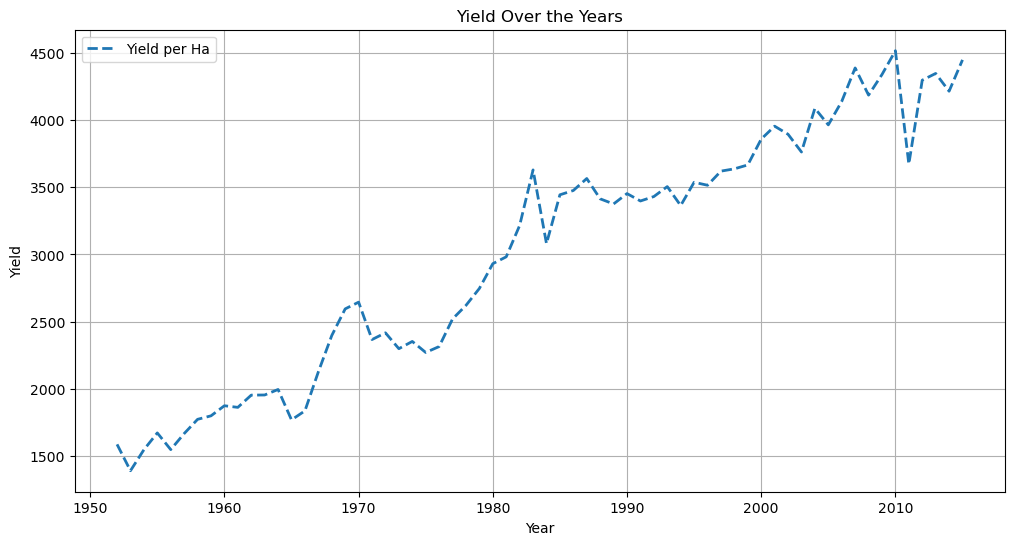

In [51]:
# Convert relevant columns to numeric (handle errors)
numeric_cols = df.columns[1:]
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

# Handle missing values
df.fillna(df.mean(), inplace=True)

# Additional Trend Analysis for Yield
plt.figure(figsize=(12, 6))
plt.plot(df['Cultivation Year'], df['Average Yield (Kg/Ha)'], label='Yield per Ha', linewidth=2, linestyle='dashed')
plt.xlabel('Year')
plt.ylabel('Yield')
plt.title('Yield Over the Years')
plt.legend()
plt.grid(True)
plt.show()



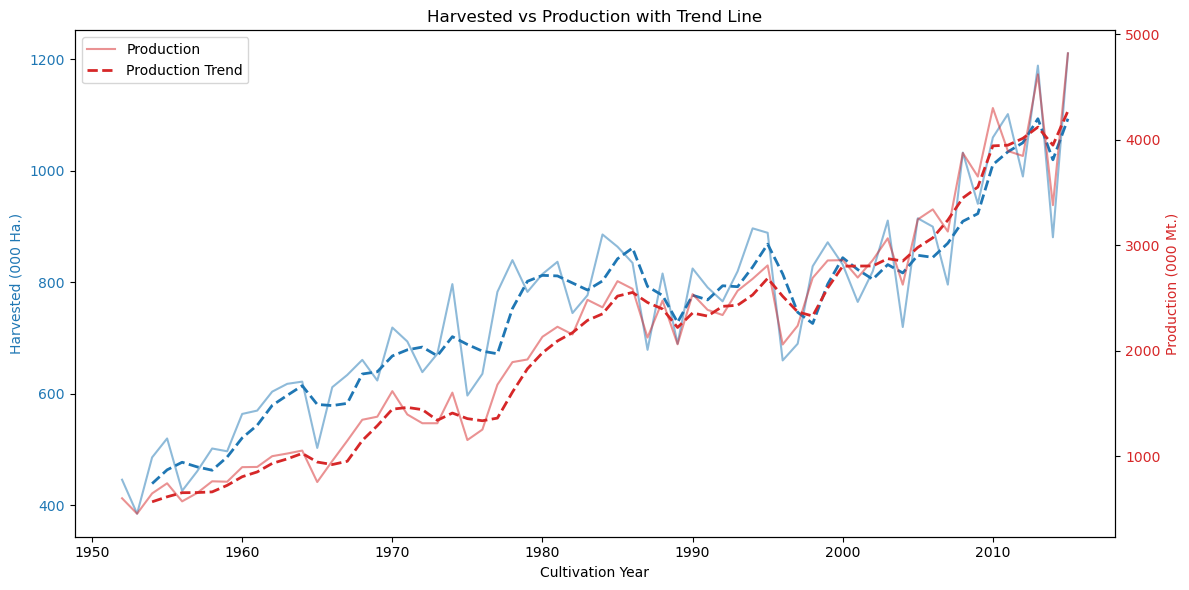

In [52]:
# Trend Moving Average 
import matplotlib.pyplot as plt
import pandas as pd

# Define Moving Average Window (e.g., 3 years)
df['Harvested_MA'] = df['Harvested (000 Ha.)'].rolling(window=3).mean()
df['Production_MA'] = df['Production (000 Mt.)'].rolling(window=3).mean()

# Create the plot
fig, ax1 = plt.subplots(figsize=(12, 6))

# Primary Y-Axis (Harvested Area)
ax1.set_xlabel('Cultivation Year')
ax1.set_ylabel('Harvested (000 Ha.)', color='tab:blue')
ax1.plot(df['Cultivation Year'], df['Harvested (000 Ha.)'], label='Harvested', color='tab:blue', alpha=0.5)
ax1.plot(df['Cultivation Year'], df['Harvested_MA'], label='Harvested Trend', color='tab:blue', linestyle='dashed', linewidth=2)
ax1.tick_params(axis='y', labelcolor='tab:blue')

# Secondary Y-Axis (Production)
ax2 = ax1.twinx()
ax2.set_ylabel('Production (000 Mt.)', color='tab:red')
ax2.plot(df['Cultivation Year'], df['Production (000 Mt.)'], label='Production', color='tab:red', alpha=0.5)
ax2.plot(df['Cultivation Year'], df['Production_MA'], label='Production Trend', color='tab:red', linestyle='dashed', linewidth=2)
ax2.tick_params(axis='y', labelcolor='tab:red')

# Title and Layout
plt.title('Harvested vs Production with Trend Line')
fig.tight_layout()
plt.legend()
plt.show()


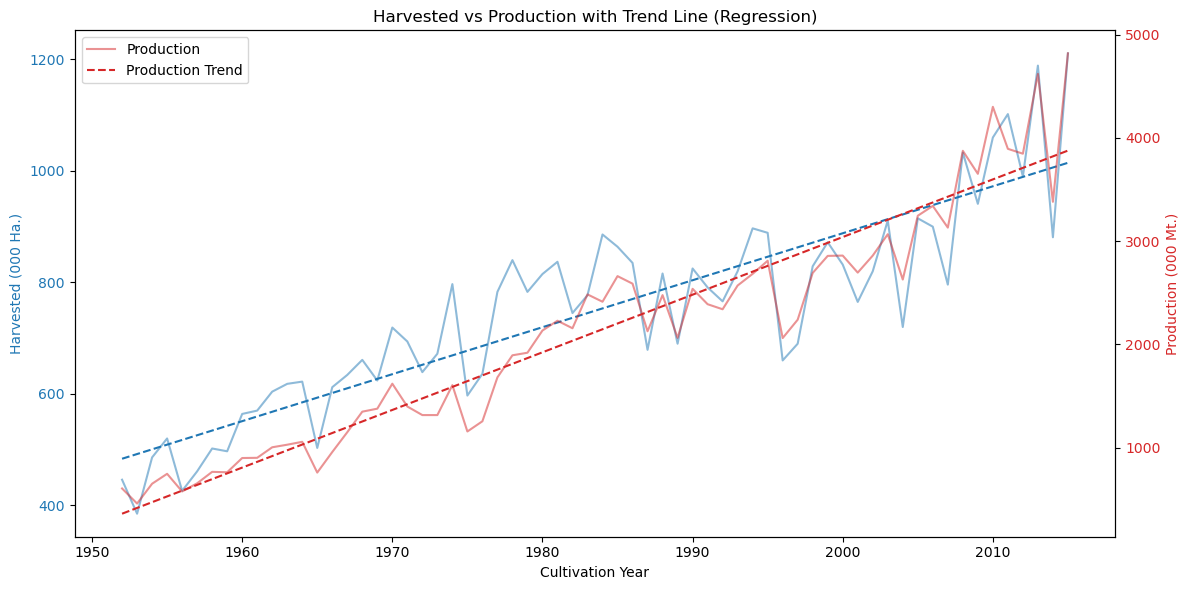

In [53]:
# Trend Regression Line 
import numpy as np

# Fit linear trend lines
z1 = np.polyfit(df['Cultivation Year'], df['Harvested (000 Ha.)'], 1)
p1 = np.poly1d(z1)  # Convert to function

z2 = np.polyfit(df['Cultivation Year'], df['Production (000 Mt.)'], 1)
p2 = np.poly1d(z2)

# Plot actual values
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Cultivation Year')
ax1.set_ylabel('Harvested (000 Ha.)', color='tab:blue')
ax1.plot(df['Cultivation Year'], df['Harvested (000 Ha.)'], label='Harvested', color='tab:blue', alpha=0.5)
ax1.plot(df['Cultivation Year'], p1(df['Cultivation Year']), label='Harvested Trend', color='tab:blue', linestyle='dashed')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Production (000 Mt.)', color='tab:red')
ax2.plot(df['Cultivation Year'], df['Production (000 Mt.)'], label='Production', color='tab:red', alpha=0.5)
ax2.plot(df['Cultivation Year'], p2(df['Cultivation Year']), label='Production Trend', color='tab:red', linestyle='dashed')
ax2.tick_params(axis='y', labelcolor='tab:red')

plt.title('Harvested vs Production with Trend Line (Regression)')
fig.tight_layout()
plt.legend()
plt.show()


# Cluster Analysis 

In [55]:
import pandas as pd

# Load the dataset
file_path = "D:/Personal/MSc/MSc. Data Science/Lecture Notes/2. Principles of DS/Assignment and Passpapers/Assignments/Portfolio/paddy_statistics_1952_2015_cleansed.csv"
df = pd.read_csv(file_path)

# Display the first few rows of the dataset
df.head()


,Cultivation Year,Sown (000 Ha),Harvested (000 Ha.),Average Yield (Kg/Ha),Production (000 Mt.)
0,1952,471,446,1588,604
1,1953,425,385,1392,458
2,1954,508,486,1548,650
3,1955,545,520,1673,746
4,1956,476,426,1549,575


C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-pa

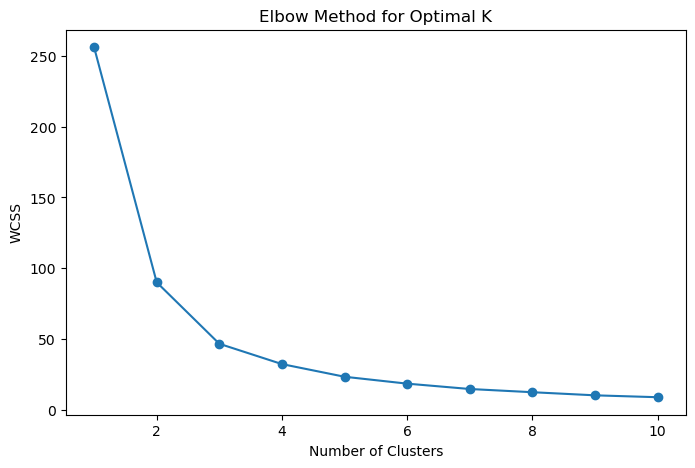

In [56]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting relevant features for clustering
features = df[['Sown (000 Ha)', 'Harvested (000 Ha.)', 'Average Yield (Kg/Ha)', 'Production (000 Mt.)']]

# Standardizing the features
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Finding the optimal number of clusters using the Elbow Method
wcss = []  # Within-cluster sum of squares
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-pa

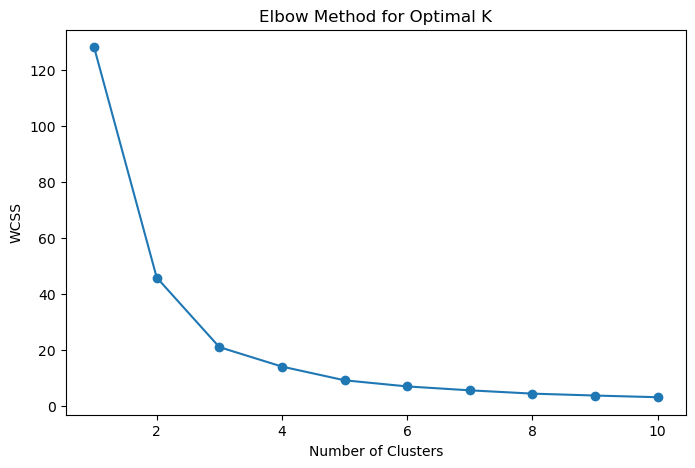

In [57]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# Selected Harvested and Production figures 
selection = df[['Harvested (000 Ha.)', 'Production (000 Mt.)']]

# Standardizing 
scaler = StandardScaler()
scaled_features = scaler.fit_transform(selection)

# Elbow Method
# Within-cluster sum of squares
wcss = []  
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42, n_init=10)
    kmeans.fit(scaled_features)
    wcss.append(kmeans.inertia_)

# Plot Elbow Curve
plt.figure(figsize=(8, 5))
plt.plot(range(1, 11), wcss, marker='o', linestyle='-')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('Elbow Method for Optimal K')
plt.show()


C:\Users\suneth.jayamanne\AppData\Local\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1446: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


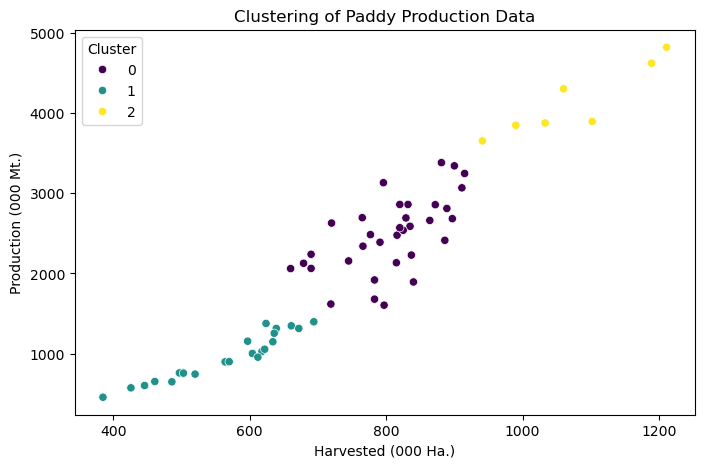

In [58]:
# Based on the elbow method, choosing an optimal number of clusters (e.g., 3 or 4)
optimal_clusters = 3

# Apply K-Means clustering
kmeans = KMeans(n_clusters=optimal_clusters, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(scaled_features)

# Visualizing the clusters using Average Yield vs Production
plt.figure(figsize=(8, 5))
sns.scatterplot(x=df['Harvested (000 Ha.)'], y=df['Production (000 Mt.)'], hue=df['Cluster'], palette='viridis')
plt.xlabel('Harvested (000 Ha.)')
plt.ylabel('Production (000 Mt.)')
plt.title('Clustering of Paddy Production Data')
plt.legend(title="Cluster")
plt.show()
